In [2]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from train_utils import update_dir_name
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [3]:
training_config = {
    'n_epochs': 100,
    'p_test': 0.1,

    'optimizer': 'Muon',
    'batch_size': 100,
    'learning_rate': 0.002,
    'weight_decay': 0.0,
    'p_electrodes_per_stream': 0.5,
    
    'train_subject_trials': [("btbank1", 0), ("btbank1", 1), ("btbank2", 4), ("btbank2", 5), ("btbank3", 1), ("btbank3", 2), ("btbank7", 1), ("btbank10", 1)],
    'eval_subject_trials': [("btbank1", 2), ("btbank2", 6), ("btbank3", 0), ("btbank7", 0), ("btbank10", 0)],
    
    'data_dtype': torch.float16,

    'random_string': "X2",
}
model_config = {
    'sample_timebin_size': 256,
    'max_frequency_bin': 64,
    'max_n_timebins': 24,
    'max_n_electrodes': 128,

    'init_normalization': True, # XXX rename to a more sensible name later

    'electrode_embedding': {
        'type': 'learned', # coordinate_init, noisy_coordinate, learned
        'coordinate_noise_std': 0.0, # only relevant for noisy_coordinate type; note coordinates are normalized to be within [0,1]
        'embedding_dim': None,
    },

    'dtype': torch.bfloat16,

    'transformer': {
        'd_model': 192,
        'n_heads': 12,
        'n_layers_electrode': 5,
        'n_layers_time': 5,
        'dropout': 0.2,
    },
}
cluster_config = {
    'save_model_every_n_epochs': 20,
    'eval_model_every_n_epochs': 5,

    'wandb_project': 'mini_bfm_exp',

    'cache_subjects': True,

    'num_workers_init': 1,
    'num_workers_dataloaders': 4,
    'num_workers_eval': 4,
    'prefetch_factor': 2,
}

In [4]:
# training_config['random_string'] = "OPT_1"
# training_config['learning_rate'] = 0.002

# training_config['optimizer'] = "Muon"
# run_id = update_dir_name(model_config, training_config, cluster_config)
# run_id

'M_nst8_iN_dm192_nh12_nl5_5_dr0.2_bs100_wd0.0_lr0.002_optMuon_rOPT_1'

In [ ]:
learning_rates = [0.00005, 0.0001, 0.0002, 0.0004, 0.001, 0.002, 0.004, 0.008]
optimizers = ["Muon", "AdamW"]
random_strings = ["OPT_1", "OPT_2", "OPT_3"]

# Initialize histories dict
histories_muon = {lr: [] for lr in learning_rates}
histories_adamw = {lr: [] for lr in learning_rates}

# Generate all run IDs and collect histories
for lr in learning_rates:
    for rs in random_strings:
        training_config['random_string'] = rs
        training_config['learning_rate'] = lr

        training_config['optimizer'] = "Muon"
        run_id = update_dir_name(model_config, training_config, cluster_config)
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories_muon[lr].append(history)
        
        training_config['optimizer'] = "AdamW"
        run_id = update_dir_name(model_config, training_config, cluster_config)
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories_adamw[lr].append(history)

for lr in learning_rates:
    print(f"learning rate {lr}: {len(histories_muon[lr])} runs of Muon")
    print(f"learning rate {lr}: {len(histories_adamw[lr])} runs of AdamW")

learning rate 5e-05: 3 runs
learning rate 5e-05: 3 runs
learning rate 0.0001: 3 runs
learning rate 0.0001: 3 runs
learning rate 0.0002: 3 runs
learning rate 0.0002: 3 runs
learning rate 0.0004: 3 runs
learning rate 0.0004: 3 runs
learning rate 0.001: 3 runs
learning rate 0.001: 3 runs
learning rate 0.002: 3 runs
learning rate 0.002: 3 runs
learning rate 0.004: 3 runs
learning rate 0.004: 3 runs
learning rate 0.008: 3 runs
learning rate 0.008: 3 runs


In [4]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3

# Initialize results dictionary
results_muon = {lr: {metric: [] for metric in metrics} 
          for lr in learning_rates}
results_adamw = {lr: {metric: [] for metric in metrics} 
          for lr in learning_rates}

# Calculate means for each run
for lr in learning_rates:
    for history in histories_muon[lr]:
        for metric in metrics:
            results_muon[lr][metric].append(history[metric].iloc[-n_last_measurements:].mean())
    for history in histories_adamw[lr]:
        for metric in metrics:
            results_adamw[lr][metric].append(history[metric].iloc[-n_last_measurements:].mean())

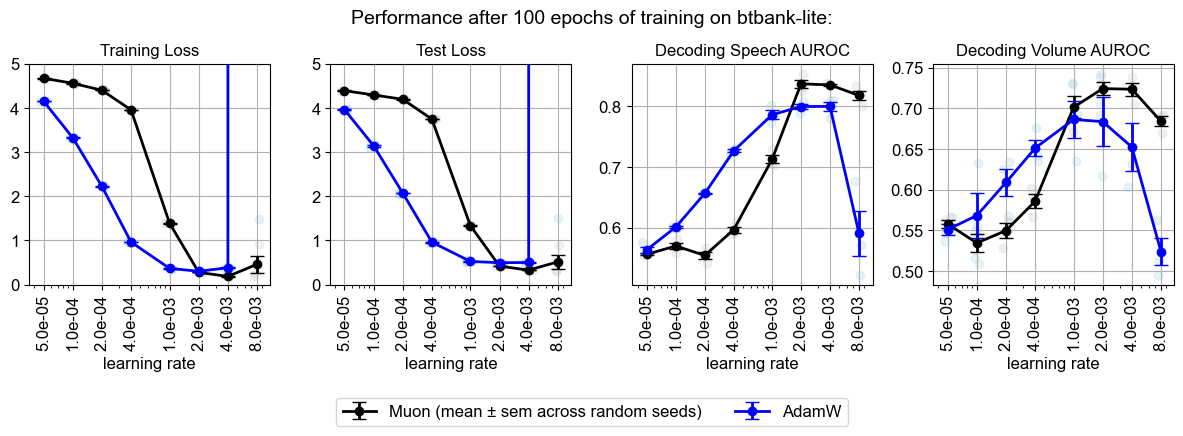

In [21]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3*len(metrics), 4))

for i, metric in enumerate(metrics):
    # Process Muon data
    means_muon = []
    errors_muon = []
    ps_muon = []
    all_values_muon = []
    all_ps_muon = []
    
    for lr in learning_rates:
        values = results_muon[lr][metric]
        if values:  # Only include if we have data
            means_muon.append(np.mean(values))
            if error_type == 'std':
                errors_muon.append(np.std(values))
            else:  # sem
                errors_muon.append(np.std(values) / np.sqrt(len(values)))
            ps_muon.append(lr)
            # Store individual points
            all_values_muon.extend(values)
            all_ps_muon.extend([lr] * len(values))

    # Process AdamW data
    means_adamw = []
    errors_adamw = []
    ps_adamw = []
    all_values_adamw = []
    all_ps_adamw = []
    
    for lr in learning_rates:
        values = results_adamw[lr][metric]
        if values:  # Only include if we have data
            means_adamw.append(np.mean(values))
            if error_type == 'std':
                errors_adamw.append(np.std(values))
            else:  # sem
                errors_adamw.append(np.std(values) / np.sqrt(len(values)))
            ps_adamw.append(lr)
            # Store individual points
            all_values_adamw.extend(values)
            all_ps_adamw.extend([lr] * len(values))
    
    # Plot individual points with some jitter and transparency
    jitter = 0.1
    # Muon points
    axes[i].scatter(
        [p * (1+np.random.uniform(-jitter, jitter)) for p in all_ps_muon],
        all_values_muon,
        alpha=0.3,
        color='lightgray',
        zorder=1
    )
    
    # AdamW points
    axes[i].scatter(
        [p * (1+np.random.uniform(-jitter, jitter)) for p in all_ps_adamw],
        all_values_adamw,
        alpha=0.3,
        color='lightblue',
        zorder=1
    )
    
    # Plot mean and error bars on top
    error_label = 'mean ± std' if error_type == 'std' else 'mean ± sem '
    error_label += 'across random seeds'
    
    # Muon line
    label = f'Muon ({error_label})' if i == 0 else None
    axes[i].errorbar(ps_muon, means_muon, yerr=errors_muon, marker='o', capsize=5, 
                    color='black', zorder=2, label=label,
                    linewidth=2)
    
    # AdamW line
    label = f'AdamW' if i == 0 else None
    axes[i].errorbar(ps_adamw, means_adamw, yerr=errors_adamw, marker='o', capsize=5, 
                    color='blue', zorder=2, label=label,
                    linewidth=2)
    
    axes[i].set_xscale('log')  # Set x-axis to log scale
    axes[i].set_xticks(learning_rates)
    axes[i].set_xticklabels([f'{lr:.1e}' for lr in learning_rates], rotation=90)  # Format tick labels and rotate 90 degrees
    axes[i].set_xlabel('learning rate')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)

axes[0].set_ylim(0, 5)
axes[1].set_ylim(0, 5)

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)

# Move legend below the figure
fig.legend(bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)

plt.tight_layout()
plt.savefig('analyses/exp_opt.pdf', bbox_inches='tight', dpi=300)
plt.show()
